In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models, datasets, transforms

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
number_of_epochs = 30

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Data loaders
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
# Initialize a dictionary to store metrics
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

In [7]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Update DataLoader batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    model = models.resnet50(pretrained=True)
    num_classes = len(train_data.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    num_epochs = 5
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = correct_train / total_train
        train_loss /= len(train_loader)
        history['train_accuracy'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = correct_val / total_val
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
    
    return best_val_accuracy

In [8]:
# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-12-03 19:38:30,105] A new study created in memory with name: no-name-bfd8a6af-c43d-4c34-bced-864866dae832
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_82182/62603749.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_82182/62603749.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warni

Epoch 1/5 - Train Loss: 0.7314, Train Accuracy: 0.4948, Val Loss: 0.8862, Val Accuracy: 0.3929
Epoch 2/5 - Train Loss: 0.6384, Train Accuracy: 0.6031, Val Loss: 0.9231, Val Accuracy: 0.3571
Epoch 3/5 - Train Loss: 0.5999, Train Accuracy: 0.6753, Val Loss: 0.8501, Val Accuracy: 0.3571
Epoch 4/5 - Train Loss: 0.5580, Train Accuracy: 0.8093, Val Loss: 0.8122, Val Accuracy: 0.3929


[I 2024-12-03 19:39:49,217] Trial 0 finished with value: 0.39285714285714285 and parameters: {'lr': 0.00024066057271900668, 'momentum': 0.8133820626155672, 'batch_size': 16}. Best is trial 0 with value: 0.39285714285714285.


Epoch 5/5 - Train Loss: 0.5224, Train Accuracy: 0.7938, Val Loss: 0.8379, Val Accuracy: 0.3929
Epoch 1/5 - Train Loss: 0.7136, Train Accuracy: 0.5309, Val Loss: 0.8224, Val Accuracy: 0.4643
Epoch 2/5 - Train Loss: 0.6063, Train Accuracy: 0.6856, Val Loss: 0.7116, Val Accuracy: 0.6429
Epoch 3/5 - Train Loss: 0.5098, Train Accuracy: 0.8144, Val Loss: 0.7429, Val Accuracy: 0.4643
Epoch 4/5 - Train Loss: 0.4339, Train Accuracy: 0.8505, Val Loss: 0.7522, Val Accuracy: 0.4643


[I 2024-12-03 19:41:08,174] Trial 1 finished with value: 0.6428571428571429 and parameters: {'lr': 0.00041334841457000773, 'momentum': 0.7904601259797713, 'batch_size': 16}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.4309, Train Accuracy: 0.8814, Val Loss: 0.7371, Val Accuracy: 0.5000
Epoch 1/5 - Train Loss: 0.7191, Train Accuracy: 0.5412, Val Loss: 0.8538, Val Accuracy: 0.4643
Epoch 2/5 - Train Loss: 0.5527, Train Accuracy: 0.7216, Val Loss: 0.7744, Val Accuracy: 0.3571
Epoch 3/5 - Train Loss: 0.4306, Train Accuracy: 0.8711, Val Loss: 0.7771, Val Accuracy: 0.6071
Epoch 4/5 - Train Loss: 0.3292, Train Accuracy: 0.8969, Val Loss: 0.8294, Val Accuracy: 0.5357


[I 2024-12-03 19:42:27,699] Trial 2 finished with value: 0.6071428571428571 and parameters: {'lr': 0.0008568285913425193, 'momentum': 0.7725057337203858, 'batch_size': 16}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.2696, Train Accuracy: 0.9485, Val Loss: 1.1026, Val Accuracy: 0.5000
Epoch 1/5 - Train Loss: 0.7016, Train Accuracy: 0.5567, Val Loss: 0.7588, Val Accuracy: 0.4286
Epoch 2/5 - Train Loss: 0.6707, Train Accuracy: 0.5309, Val Loss: 0.8183, Val Accuracy: 0.5000
Epoch 3/5 - Train Loss: 0.6500, Train Accuracy: 0.6443, Val Loss: 0.7575, Val Accuracy: 0.5000
Epoch 4/5 - Train Loss: 0.6313, Train Accuracy: 0.6392, Val Loss: 0.7522, Val Accuracy: 0.5357


[I 2024-12-03 19:43:47,176] Trial 3 finished with value: 0.5714285714285714 and parameters: {'lr': 0.00010397144370945573, 'momentum': 0.7759628978266392, 'batch_size': 16}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.6069, Train Accuracy: 0.6907, Val Loss: 0.7543, Val Accuracy: 0.5714
Epoch 1/5 - Train Loss: 0.7816, Train Accuracy: 0.5103, Val Loss: 0.6794, Val Accuracy: 0.5714
Epoch 2/5 - Train Loss: 0.7244, Train Accuracy: 0.6186, Val Loss: 0.7076, Val Accuracy: 0.5714
Epoch 3/5 - Train Loss: 0.6072, Train Accuracy: 0.7216, Val Loss: 0.6913, Val Accuracy: 0.5357
Epoch 4/5 - Train Loss: 0.5755, Train Accuracy: 0.7629, Val Loss: 0.6906, Val Accuracy: 0.5714


[I 2024-12-03 19:44:51,734] Trial 4 finished with value: 0.5714285714285714 and parameters: {'lr': 0.0004049222836390338, 'momentum': 0.9718189709639478, 'batch_size': 64}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.5150, Train Accuracy: 0.8814, Val Loss: 0.6845, Val Accuracy: 0.5714
Epoch 1/5 - Train Loss: 0.7598, Train Accuracy: 0.4381, Val Loss: 0.7497, Val Accuracy: 0.5714
Epoch 2/5 - Train Loss: 0.7811, Train Accuracy: 0.4485, Val Loss: 0.7537, Val Accuracy: 0.4643
Epoch 3/5 - Train Loss: 0.7273, Train Accuracy: 0.4948, Val Loss: 0.7545, Val Accuracy: 0.4643
Epoch 4/5 - Train Loss: 0.6663, Train Accuracy: 0.5619, Val Loss: 0.7381, Val Accuracy: 0.4643


[I 2024-12-03 19:45:55,785] Trial 5 finished with value: 0.5714285714285714 and parameters: {'lr': 4.897017485396799e-05, 'momentum': 0.8756790714575279, 'batch_size': 64}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.6488, Train Accuracy: 0.5825, Val Loss: 0.7358, Val Accuracy: 0.4286
Epoch 1/5 - Train Loss: 0.6836, Train Accuracy: 0.5619, Val Loss: 0.7484, Val Accuracy: 0.4643
Epoch 2/5 - Train Loss: 0.6845, Train Accuracy: 0.6031, Val Loss: 0.7545, Val Accuracy: 0.3929
Epoch 3/5 - Train Loss: 0.6552, Train Accuracy: 0.6289, Val Loss: 0.7390, Val Accuracy: 0.5714
Epoch 4/5 - Train Loss: 0.6391, Train Accuracy: 0.6134, Val Loss: 0.7720, Val Accuracy: 0.5000


[I 2024-12-03 19:47:04,660] Trial 6 finished with value: 0.5714285714285714 and parameters: {'lr': 7.065439872646433e-05, 'momentum': 0.7141330470312195, 'batch_size': 32}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.6206, Train Accuracy: 0.6289, Val Loss: 0.7652, Val Accuracy: 0.5000
Epoch 1/5 - Train Loss: 0.7426, Train Accuracy: 0.4639, Val Loss: 0.7065, Val Accuracy: 0.5714
Epoch 2/5 - Train Loss: 0.7232, Train Accuracy: 0.4588, Val Loss: 0.6533, Val Accuracy: 0.6429
Epoch 3/5 - Train Loss: 0.7068, Train Accuracy: 0.5309, Val Loss: 0.7000, Val Accuracy: 0.6071
Epoch 4/5 - Train Loss: 0.7392, Train Accuracy: 0.5206, Val Loss: 0.7239, Val Accuracy: 0.5714


[I 2024-12-03 19:48:08,700] Trial 7 finished with value: 0.6428571428571429 and parameters: {'lr': 1.6951386384371635e-05, 'momentum': 0.8154819300036306, 'batch_size': 64}. Best is trial 1 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.6930, Train Accuracy: 0.5464, Val Loss: 0.7411, Val Accuracy: 0.6071
Epoch 1/5 - Train Loss: 0.6564, Train Accuracy: 0.5979, Val Loss: 2.2607, Val Accuracy: 0.4286
Epoch 2/5 - Train Loss: 0.5401, Train Accuracy: 0.7680, Val Loss: 0.5659, Val Accuracy: 0.7143
Epoch 3/5 - Train Loss: 0.3947, Train Accuracy: 0.8247, Val Loss: 0.6262, Val Accuracy: 0.7143
Epoch 4/5 - Train Loss: 0.4176, Train Accuracy: 0.8660, Val Loss: 1.2770, Val Accuracy: 0.5714


[I 2024-12-03 19:49:28,303] Trial 8 finished with value: 0.8214285714285714 and parameters: {'lr': 0.003968272070503811, 'momentum': 0.7849555224275542, 'batch_size': 16}. Best is trial 8 with value: 0.8214285714285714.


Epoch 5/5 - Train Loss: 0.3672, Train Accuracy: 0.8608, Val Loss: 0.9496, Val Accuracy: 0.8214
Epoch 1/5 - Train Loss: 0.6990, Train Accuracy: 0.5155, Val Loss: 0.7856, Val Accuracy: 0.4286
Epoch 2/5 - Train Loss: 0.6381, Train Accuracy: 0.6082, Val Loss: 0.8815, Val Accuracy: 0.5000
Epoch 3/5 - Train Loss: 0.6166, Train Accuracy: 0.6701, Val Loss: 0.9245, Val Accuracy: 0.5000
Epoch 4/5 - Train Loss: 0.5428, Train Accuracy: 0.7732, Val Loss: 0.8229, Val Accuracy: 0.4643


[I 2024-12-03 19:50:47,157] Trial 9 finished with value: 0.6071428571428571 and parameters: {'lr': 0.00026546196047225163, 'momentum': 0.7866529896959936, 'batch_size': 16}. Best is trial 8 with value: 0.8214285714285714.


Epoch 5/5 - Train Loss: 0.5044, Train Accuracy: 0.8144, Val Loss: 0.8648, Val Accuracy: 0.6071


In [9]:
# Best hyperparameters
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

Best Hyperparameters: {'lr': 0.003968272070503811, 'momentum': 0.7849555224275542, 'batch_size': 16}


In [10]:
# Final model training with best hyperparameters
best_model = models.resnet50(pretrained=True)
best_model.fc = nn.Linear(best_model.fc.in_features, len(train_data.classes))
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    best_model.parameters(),
    lr=best_hyperparams['lr'],
    momentum=best_hyperparams['momentum']
)

In [12]:
train_loader = DataLoader(train_data, batch_size=best_hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=best_hyperparams['batch_size'], shuffle=False)

In [13]:

for epoch in range(number_of_epochs):
    best_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Training completed with best hyperparameters!")


Training completed with best hyperparameters!


In [14]:
file_name = f'Pth_Files/Resnet50_model_Hyperparmeter_{number_of_epochs}.keras'

In [15]:
torch.save(best_model.state_dict(), 'best_resnet50_model.pth')

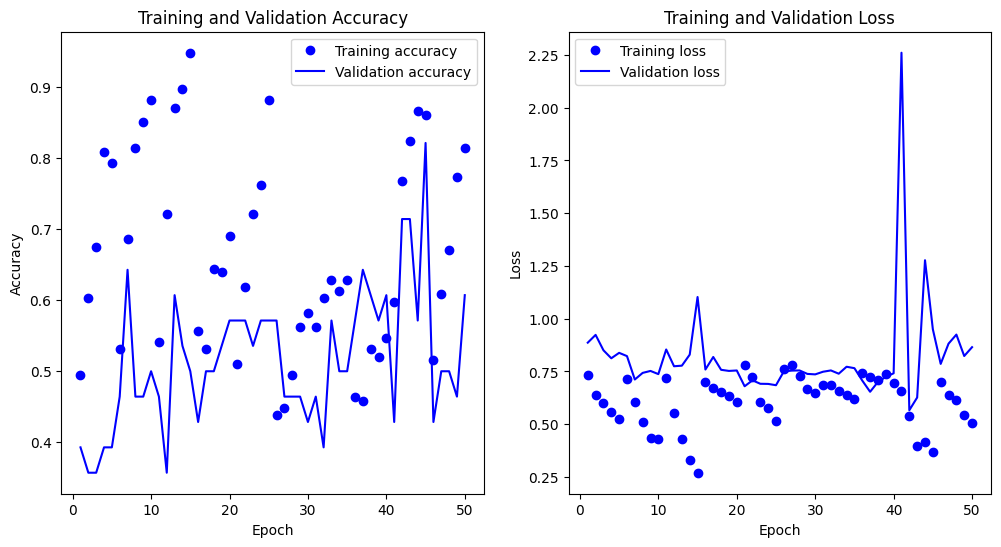

In [17]:
# Plot training & validation accuracy values
acc = history['train_accuracy']
val_acc = history['val_accuracy']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

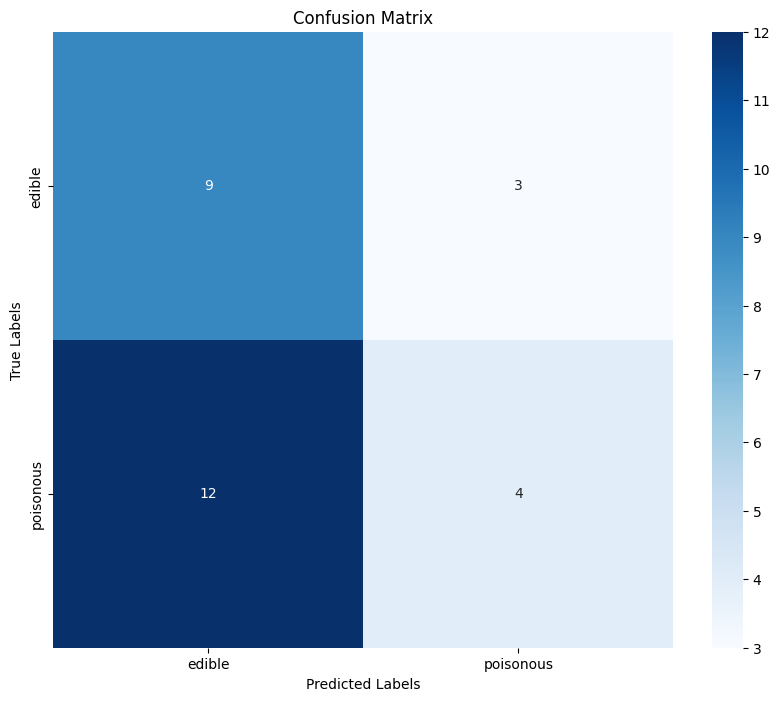

Classification Report:
              precision    recall  f1-score   support

      edible       0.43      0.75      0.55        12
   poisonous       0.57      0.25      0.35        16

    accuracy                           0.46        28
   macro avg       0.50      0.50      0.45        28
weighted avg       0.51      0.46      0.43        28



In [ ]:
best_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
classes = train_data.classes  # Class names

# Plot confusion matrix with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))